In [85]:
seed = 13427256

# Q10

You want to create a “personal mixtape” for all 10k users we have explicit feedback for. This mixtape contains individualized recommendations as to which 10 songs (out of the 5k) a given user will enjoy most. How do these recommendations compare to the “greatest hits” from the previous question and how good is your recommender system in making recommendations?

In [86]:
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm

np.random.seed(seed)

In [87]:
df_songs = pd.read_csv("spotify52kData.csv").iloc[:5000].sort_values(by='popularity', ascending=False)

In [88]:
indices_of_duplicates = df_songs[df_songs.duplicated(keep='first', subset=['artists', 'album_name', 'track_name', 'popularity'])].index.tolist()

In [89]:
df_songs = df_songs.drop(indices_of_duplicates).sort_values(by='songNumber')

In [90]:
df_stars = pd.read_parquet("starRatings.parquet").drop(columns=indices_of_duplicates)

In [91]:
df_songs.columns

Index(['songNumber', 'artists', 'album_name', 'track_name', 'popularity',
       'duration', 'explicit', 'danceability', 'energy', 'key', 'loudness',
       'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'time_signature', 'track_genre'],
      dtype='object')

In [8]:
df_songs['track_genre'].value_counts() # Seems to be distributed decently well. Will use the variable.

acoustic       1000
afrobeat        999
ambient         999
alt-rock        763
alternative     637
Name: track_genre, dtype: int64

In [80]:
df_songs

,songNumber,artists,album_name,track_name,popularity,duration,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,Gen Hoshino,Comedy,Comedy,73,230666,False,0.6760,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.7150,87.917,4,acoustic
1,1,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.4200,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.2670,77.489,4,acoustic
2,2,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.4380,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.1200,76.332,4,acoustic
3,3,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.2660,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.1430,181.740,3,acoustic
4,4,Chord Overstreet,Hold On,Hold On,82,198853,False,0.6180,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.1670,119.949,4,acoustic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,4995,Ludovico Einaudi,Elements (Deluxe),Drop,49,300293,False,0.4650,0.0342,2,-28.257,0,0.0401,0.9920,0.939000,0.1030,0.0590,152.054,4,ambient
4996,4996,Air,Moon Safari,Kelly Watch the Stars,55,226293,False,0.5160,0.7430,2,-8.470,1,0.0292,0.2820,0.637000,0.1110,0.2260,109.837,4,ambient
4997,4997,Ludovico Einaudi,Islands - Essential Einaudi,Passagio,50,357773,False,0.2220,0.0200,9,-27.114,1,0.0464,0.9950,0.948000,0.0945,0.1190,85.860,4,ambient
4998,4998,Liquid Mind,Liquid Mind II: Slow World,Blue Seven,24,760053,False,0.0576,0.1690,10,-20.216,1,0.0484,0.9030,0.966000,0.1170,0.0310,50.838,4,ambient


In [9]:
df_songs['mode'].value_counts() # Seems to be distributed decently well. Will use the variable.

1    2787
0    1611
Name: mode, dtype: int64

In [10]:
df_songs['time_signature'].value_counts() # Most are in the 4 time signature, will not use the variable.

4    3758
3     496
5      85
1      55
0       4
Name: time_signature, dtype: int64

In [11]:
df_songs['explicit'].value_counts() # Will include the variable out of the theory that explicit listeners exist.

False    4140
True      258
Name: explicit, dtype: int64

## Approach
Create a model that predicts y := rating given to song for each predicted user.
For a user, run all 5000 models, get predicted ratings, and order for the top 10 songs.

## Data

We will do a 90/10 split. The 10 is a holdout set of users to evaluate our model on.

For the other 90, do a 80/20 split for CV/hyperparameter search.

## Feature Engineering

Since we are training a model per song, we only need per-user features. All of the features will be calculated for the user, without taking into account anything regarding the song being evaluated. Therefore, there will be 5000 feature engineering processes.

Features:
- User average rating (average rating the user gives across all songs).
- Weighted average var rating (average of var, weighted by the songs' given rating). Across the variables:
    - Popularity
    - Duration
    - Danceability
    - Energy
    - Loudness
    - Speechiness
    - Acousticness
    - Instrumentalness
    - Liveness
    - Valence
    - Tempo
- For each genre in track_genre:
    - genre_listen_perc (of the ratings, how many are of this genre).
- For each mode in mode:
    - mode_listen_perc (of the ratings, how many are of thise mode).
- Explicit hearing % (of the ratings, how many of the songs are explicit).

In [12]:
def generate_user_features(user_number):
    """
    Generates a user's features. Assumes that the effect of the song to predict for is negligible next to the other songs.
    """
    
    features = {}
    features['average_rating'] = df_stars.loc[user_number].mean()
    
    user_weights = df_stars.loc[user_number].fillna(0)

    # Generate weighted numeric variables
    for col in ['popularity', 'duration', 'danceability', 'energy',
              'loudness', 'speechiness', 'acousticness', 'instrumentalness',
              'liveness', 'valence', 'tempo']:
        features[f"{col}_weighted"] = np.average(df_songs[col], weights=user_weights)

    usr_song_idx = list(df_stars.columns[~df_stars.loc[user_number].isna()])
    df_usr_songs = df_songs.loc[usr_song_idx]
    
    features['explicit_percentage'] = df_usr_songs['explicit'].sum()/len(df_usr_songs)

    # Generate categorical variable percentage values
    for col in ['track_genre', 'mode']:
        for value in df_songs[col].unique():
            features[f'{col}_{value}'] = (df_usr_songs[col] == value).sum()/len(df_usr_songs)
            
    return features

In [13]:
user_features = [generate_user_features(i) for i in tqdm(range(len(df_stars)))]
df_features = pd.DataFrame(user_features)

100%|██████████| 10000/10000 [00:18<00:00, 541.99it/s]


In [14]:
df_features

,average_rating,popularity_weighted,duration_weighted,danceability_weighted,energy_weighted,loudness_weighted,speechiness_weighted,acousticness_weighted,instrumentalness_weighted,liveness_weighted,valence_weighted,tempo_weighted,explicit_percentage,track_genre_acoustic,track_genre_afrobeat,track_genre_alt-rock,track_genre_alternative,track_genre_ambient,mode_0,mode_1
0,1.543340,40.698630,231069.716438,0.562410,0.651177,-7.087533,0.058111,0.299797,0.135337,0.187617,0.488604,119.734399,0.057082,0.241015,0.224101,0.177590,0.152220,0.205074,0.395349,0.604651
1,2.371703,39.143579,237093.957533,0.535555,0.584662,-8.855089,0.060762,0.362109,0.152014,0.181933,0.456189,120.695888,0.057554,0.196643,0.232614,0.182254,0.143885,0.244604,0.369305,0.630695
2,2.676399,39.098182,230664.930000,0.541894,0.570573,-9.433720,0.064987,0.395050,0.194156,0.183515,0.481872,118.809024,0.063260,0.270073,0.272506,0.163017,0.121655,0.172749,0.328467,0.671533
3,2.073913,39.197065,228971.525157,0.540004,0.582653,-8.516239,0.062756,0.377842,0.173686,0.173280,0.452065,119.830908,0.050000,0.195652,0.239130,0.180435,0.147826,0.236957,0.345652,0.654348
4,2.786070,39.333036,224320.919643,0.523871,0.538657,-10.108101,0.056915,0.436177,0.238713,0.180454,0.444525,119.836990,0.047264,0.241294,0.221393,0.161692,0.129353,0.246269,0.355721,0.644279
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.851415,44.387812,240645.842105,0.568042,0.737590,-5.979740,0.061754,0.211304,0.083541,0.187216,0.536768,120.497834,0.058962,0.228774,0.242925,0.169811,0.134434,0.224057,0.372642,0.627358
9996,1.909314,39.101412,232200.403081,0.563964,0.609919,-7.919357,0.064315,0.356301,0.140584,0.177809,0.460350,121.798874,0.046569,0.250000,0.227941,0.188725,0.127451,0.205882,0.394608,0.605392
9997,2.759009,37.777143,233432.452245,0.535404,0.579235,-8.848654,0.054640,0.380913,0.176346,0.183903,0.461624,120.585586,0.049550,0.247748,0.180180,0.209459,0.139640,0.222973,0.378378,0.621622
9998,1.751678,40.072797,235228.315453,0.561215,0.645046,-7.459789,0.061860,0.295369,0.122682,0.194801,0.492854,118.876019,0.078300,0.248322,0.221477,0.158837,0.181208,0.190157,0.380313,0.619687


In [15]:
def generate_datasets(test_prop = 0.1, eval_prop = 0.2):
    #First reserve 10% of all users, in order to evaluate the model.
    all_user_ids = list(range(len(df_features)))
    
    #90/10 split
    len_test_users = int(np.ceil(len(df_features) * test_prop))
    test_users = np.random.choice(all_user_ids, size = len_test_users, replace = False)
    non_test_users = [u for u in all_user_ids if u not in test_users]

    #Generate the per-song datasets
    song_train_idx = dict()
    song_val_idx = dict()
    
    for s in tqdm(df_songs.songNumber):
        #80/20 split over the users that rated the song, for users not in the test dataset.
        song_users  = (df_stars[~df_stars[s].isna()]).index
        non_test_song_users = list(set(song_users).intersection(set(non_test_users)))
    
        len_song_val_users = int(np.ceil(len(non_test_song_users) * eval_prop))
        song_val_users = np.random.choice(non_test_song_users, size = len_song_val_users, replace = False)
    
        song_train_users = [u for u in non_test_song_users if u not in song_val_users]
    
        song_train_idx[s] = song_train_users
        song_val_idx[s] = song_val_users

    return test_users, song_train_idx, song_val_idx

In [16]:
try:
    # Try to load the existing datasets
    test_users = joblib.load("q10_test_users.pkl")
    song_train_idx = joblib.load("q10_song_train_idx.pkl")
    song_val_idx = joblib.load("q10_song_val_idx.pkl")
    print("Loaded existing datasets.")
except:
    # If the file doesn't exist, create and save the models
    print("Datasets not found. Generating...")

    test_users, song_train_idx, song_val_idx = generate_datasets()
    # Save the datasets
    joblib.dump(test_users, "q10_test_users.pkl")
    joblib.dump(song_train_idx, "q10_song_train_idx.pkl")
    joblib.dump(song_val_idx, "q10_song_val_idx.pkl")
    print("Generated/saved datasets.")

Loaded existing datasets.


### Training loop

Lasso Regression to start.

In [17]:
import optuna
import numpy as np
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

sampler = optuna.samplers.TPESampler(seed=seed)  # Make the sampler behave in a deterministic way.

optuna.logging.set_verbosity(optuna.logging.WARNING)

In [18]:
def get_sample_weights(y_true):
    return np.sqrt((y_true+2)/3)

def weighted_mse(y_true, y_pred):
    """
    Custom loss function that gives more weight to errors where the actual value is higher.
    """
    # Calculate squared errors
    squared_errors = (y_true - y_pred) ** 2
    
    # Weight errors by actual values
    weighted_errors = squared_errors * get_sample_weights(y_true)
    
    # Return mean weighted error
    return np.mean(weighted_errors)


def get_pipeline(**kwargs):
    return Pipeline([
                ('scaler', StandardScaler()),
                ('model', Lasso(**kwargs))
            ])

def train_song_model(song_number):

    X_train = df_features.loc[song_train_idx[song_number]].values
    y_train = df_stars[song_number].loc[song_train_idx[song_number]].values

    X_val = df_features.loc[song_val_idx[song_number]].values
    y_val = df_stars[song_number].loc[song_val_idx[song_number]].values
    
    sample_weights = get_sample_weights(y_train)
    
    def objective(trial):
        params = dict()
        params['alpha'] = trial.suggest_float("alpha", 0.001, 3.0, log=True)
        pipeline = get_pipeline(**params)
        pipeline.fit(X_train, y_train, model__sample_weight = sample_weights)
        y_pred = pipeline.predict(X_val)
        wmse = weighted_mse(y_val, y_pred)
        return wmse

    # Create an Optuna study
    study = optuna.create_study(direction="minimize", sampler=sampler)
    
    # Optimize the Lasso hyperparameters
    study.optimize(objective, n_trials=150)
    
    # Train the model with the best hyperparameters
    pipeline = get_pipeline(**study.best_params)
    pipeline.fit(X_train, y_train, model__sample_weight = sample_weights)
    return pipeline

In [19]:
songs = df_songs.songNumber.values

In [20]:
try:
    # Try to load the existing model dictionary
    song_models = joblib.load("q10_song_models.pkl")
    print("Loaded existing model dictionary.")
except:
    # If the file doesn't exist, create and save the models
    print("Model dictionary not found. Training models...")

    song_models = {s:train_song_model(s) for s in tqdm(songs)}
    # Save the trained models
    joblib.dump(song_models, "q10_song_models.pkl")
    print("Trained models and saved model dictionary.")

Model dictionary not found. Training models...


100%|██████████| 4398/4398 [3:04:32<00:00,  2.52s/it]  


Trained models and saved model dictionary.


# Model evaluation

In [21]:
def pred_user(usr_number):
    """ Gives the real ranking (by rating), and the full prediction by preference of a single user."""
    X = df_features.loc[[usr_number]]
    y = df_stars.loc[usr_number].fillna(0)
    usr_ratings = df_stars.loc[usr_number]
    listened = usr_ratings.dropna().index.tolist()
    liked = usr_ratings[usr_ratings > 3].index.to_list()
    y_pred = [(s, song_models[s].predict(X.values)[0]) for s in songs]
    pred_order = [x[0] for x in sorted(y_pred, key=lambda x: x[1], reverse=True)]
    real_order = list(y.sort_values(ascending=False).index)
    return real_order, pred_order, listened, liked

In [22]:
test_user_ratings = [pred_user(u) for u in tqdm(test_users)]

100%|██████████| 1000/1000 [03:25<00:00,  4.88it/s]


How do these recommendations compare to the “greatest hits” from the previous question?

In [23]:
#From Q9, the average star rating based ranking
avg_star_rating_order = joblib.load('q9_avg_star_rating.pkl')

In [24]:
#Will use Jaccard similarity to measure how similar the users' top 10 lists are when compared to the popularity-based model.

def jaccard(set1, set2):
    set1 = set(set1)
    set2 = set(set2)
    # intersection of two sets
    intersection = len(set1.intersection(set2))
    # Unions of two sets
    union = len(set1.union(set2))
     
    return intersection / union

In [25]:
# Using Jaccard similarity to check how similar our predictions are to the popularity model's
similarities = [jaccard([x for x in r[1] if x not in r[2]][:10],
                        [x for x in avg_star_rating_order if x not in r[2]][:10])
                for r in tqdm(test_user_ratings)
               ]

100%|██████████| 1000/1000 [02:50<00:00,  5.86it/s]


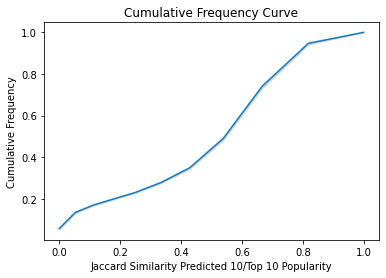

In [26]:
data_sorted = sorted(similarities)

# Calculating the cumulative frequency
cumulative_frequency = np.linspace(0., 1., len(similarities))

# Creating the plot
sns.lineplot(x=data_sorted, y=cumulative_frequency)
plt.xlabel('Jaccard Similarity Predicted 10/Top 10 Popularity')
plt.ylabel('Cumulative Frequency')
plt.title('Cumulative Frequency Curve')

# Show the plot
plt.show()

In [27]:
np.mean(similarities)

0.47174216675996866

In [28]:
np.median(similarities)

0.5384615384615384

How good is your recommender system in making recommendations?

In [29]:
#Using average precision @k to evaluate
def average_precision(ground_truth, prediction, k=100):
    hits = 0
    sum_precisions = 0
    ground_truth = ground_truth#[:k]
    prediction = prediction[:k]
    for i, p in enumerate(prediction):
        if p in ground_truth:
            hits += 1
            precision_at_i = hits / (i + 1)
            sum_precisions += precision_at_i

    return sum_precisions / k

## K = 10

In [83]:
at_k = 10

In [127]:
pred_average_precisions = []
pop_average_precisions = []

for real, pred, listened, liked in test_user_ratings:
    pred_average_precisions.append(average_precision(liked, pred, k=at_k))
    pop_average_precisions.append(average_precision(liked, avg_star_rating_order, k=at_k))


### Our model

Text(0.5, 1.0, 'Histogram of Mean Average Precision @10 (ML Model)')

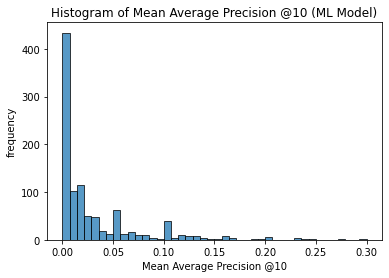

In [128]:
sns.histplot(pred_average_precisions)
plt.xlabel(f'Mean Average Precision @{at_k}')
plt.ylabel('frequency')
plt.title(f'Histogram of Mean Average Precision @{at_k} (ML Model)')

In [129]:
np.mean(pred_average_precisions)

0.02801535714285714

In [130]:
np.median(pred_average_precisions)

0.0125

### Popularity-based model

Text(0.5, 1.0, 'Histogram of Mean Average Precision @10 (Popularity Model)')

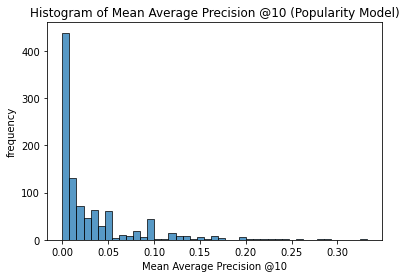

In [131]:
sns.histplot(pop_average_precisions)
plt.xlabel(f'Mean Average Precision @{at_k}')
plt.ylabel('frequency')
plt.title(f'Histogram of Mean Average Precision @{at_k} (Popularity Model)')

In [132]:
np.mean(pop_average_precisions)

0.029461547619047616

In [133]:
np.median(pop_average_precisions)

0.0125

## K = 20

In [38]:
at_k = 20

In [39]:
pred_average_precisions = []
pop_average_precisions = []

for real, pred, listened, liked in test_user_ratings:
    pred_average_precisions.append(average_precision(liked, pred, k=at_k))
    pop_average_precisions.append(average_precision(liked, avg_star_rating_order, k=at_k))


### Our model

Text(0.5, 1.0, 'Histogram of Mean Average Precision @20 (ML Model)')

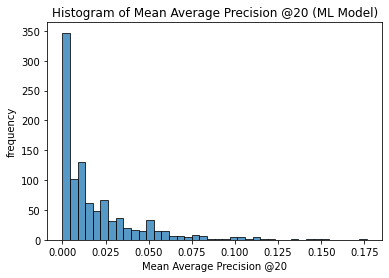

In [40]:
sns.histplot(pred_average_precisions)
plt.xlabel(f'Mean Average Precision @{at_k}')
plt.ylabel('frequency')
plt.title(f'Histogram of Mean Average Precision @{at_k} (ML Model)')

In [41]:
np.mean(pred_average_precisions)

0.019339218985349012

In [42]:
np.median(pred_average_precisions)

0.010098581973581974

### Popularity-based model

Text(0.5, 1.0, 'Histogram of Mean Average Precision @20 (Popularity Model)')

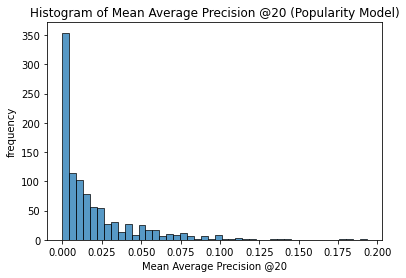

In [43]:
sns.histplot(pop_average_precisions)
plt.xlabel(f'Mean Average Precision @{at_k}')
plt.ylabel('frequency')
plt.title(f'Histogram of Mean Average Precision @{at_k} (Popularity Model)')

In [44]:
np.mean(pop_average_precisions)

0.019652443269879413

In [45]:
np.median(pop_average_precisions)

0.01

## K = 50

In [46]:
at_k = 50

In [47]:
pred_average_precisions = []
pop_average_precisions = []

for real, pred, listened, liked in test_user_ratings:
    pred_average_precisions.append(average_precision(liked, pred, k=at_k))
    pop_average_precisions.append(average_precision(liked, avg_star_rating_order, k=at_k))


### Our model

Text(0.5, 1.0, 'Histogram of Mean Average Precision @50 (ML Model)')

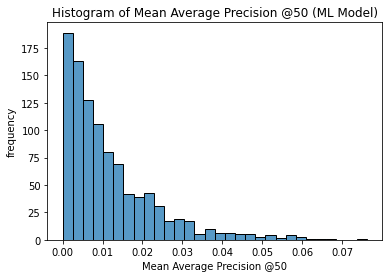

In [48]:
sns.histplot(pred_average_precisions)
plt.xlabel(f'Mean Average Precision @{at_k}')
plt.ylabel('frequency')
plt.title(f'Histogram of Mean Average Precision @{at_k} (ML Model)')

In [49]:
np.mean(pred_average_precisions)

0.011715304290472116

In [50]:
np.median(pred_average_precisions)

0.007877691811734366

### Popularity-based model

Text(0.5, 1.0, 'Histogram of Mean Average Precision @50 (Popularity Model)')

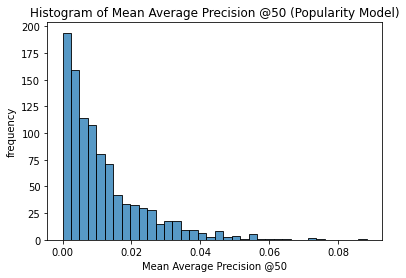

In [51]:
sns.histplot(pop_average_precisions)
plt.xlabel(f'Mean Average Precision @{at_k}')
plt.ylabel('frequency')
plt.title(f'Histogram of Mean Average Precision @{at_k} (Popularity Model)')

In [52]:
np.mean(pop_average_precisions)

0.011814903517910794

In [53]:
np.median(pop_average_precisions)

0.007983946085990994

## K = 100

In [54]:
at_k = 100

In [55]:
pred_average_precisions = []
pop_average_precisions = []

for real, pred, listened, liked in test_user_ratings:
    pred_average_precisions.append(average_precision(liked, pred, k=at_k))
    pop_average_precisions.append(average_precision(liked, avg_star_rating_order, k=at_k))


### Our model

Text(0.5, 1.0, 'Histogram of Mean Average Precision @100 (ML Model)')

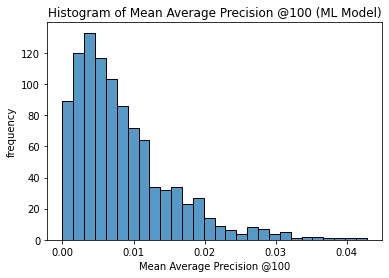

In [56]:
sns.histplot(pred_average_precisions)
plt.xlabel(f'Mean Average Precision @{at_k}')
plt.ylabel('frequency')
plt.title(f'Histogram of Mean Average Precision @{at_k} (ML Model)')

In [57]:
np.mean(pred_average_precisions)

0.008478569638130843

In [58]:
np.median(pred_average_precisions)

0.006638970748650627

### Popularity-based model

Text(0.5, 1.0, 'Histogram of Mean Average Precision @100 (Popularity Model)')

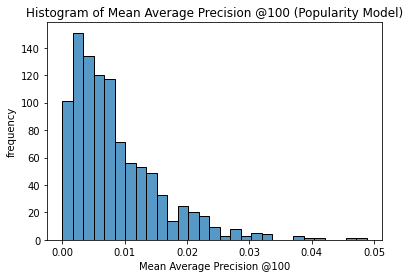

In [59]:
sns.histplot(pop_average_precisions)
plt.xlabel(f'Mean Average Precision @{at_k}')
plt.ylabel('frequency')
plt.title(f'Histogram of Mean Average Precision @{at_k} (Popularity Model)')

In [60]:
np.mean(pop_average_precisions)

0.008495571195227229

In [61]:
np.median(pop_average_precisions)

0.006645962013315746

## K = 200

In [62]:
at_k = 200

In [63]:
pred_average_precisions = []
pop_average_precisions = []

for real, pred, listened, liked in test_user_ratings:
    pred_average_precisions.append(average_precision(liked, pred, k=at_k))
    pop_average_precisions.append(average_precision(liked, avg_star_rating_order, k=at_k))


### Our model

Text(0.5, 1.0, 'Histogram of Mean Average Precision @200 (ML Model)')

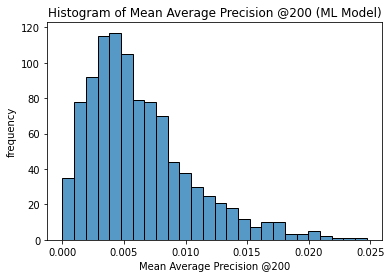

In [64]:
sns.histplot(pred_average_precisions)
plt.xlabel(f'Mean Average Precision @{at_k}')
plt.ylabel('frequency')
plt.title(f'Histogram of Mean Average Precision @{at_k} (ML Model)')

In [65]:
np.mean(pred_average_precisions)

0.0062681532189157105

In [66]:
np.median(pred_average_precisions)

0.005282630646564106

### Popularity-based model

Text(0.5, 1.0, 'Histogram of Mean Average Precision @200 (Popularity Model)')

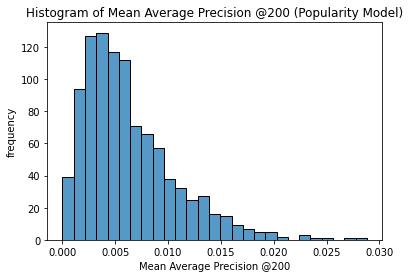

In [67]:
sns.histplot(pop_average_precisions)
plt.xlabel(f'Mean Average Precision @{at_k}')
plt.ylabel('frequency')
plt.title(f'Histogram of Mean Average Precision @{at_k} (Popularity Model)')

In [68]:
np.mean(pop_average_precisions)

0.006304672912636617

In [69]:
np.median(pop_average_precisions)

0.005288095131910897